In [39]:
!pip install panda-gym

# Replay Buffer

In [40]:
import numpy as np

class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.size = max_size
        self.counter = 0
        self.states = np.zeros((max_size, input_shape))
        self.actions = np.zeros((max_size, n_actions))
        self.rewards = np.zeros(max_size)
        self.new_states = np.zeros((max_size, input_shape))
        self.terminal_state = np.zeros(max_size)

    def store_transition(self, state, action, reward, new_state, done):
        index = self.counter % self.size

        self.states[index] = state
        self.actions[index] = action
        self.rewards[index] = reward
        self.new_states[index] = new_state
        self.terminal_state[index] = done

        self.counter += 1

    def sample(self, batch_size):
        max_memory = min(self.size, self.counter)
        batch = np.random.choice(max_memory, batch_size, replace=False)

        states = self.states[batch]
        actions = self.actions[batch]
        rewards = self.rewards[batch]
        new_states = self.new_states[batch]
        dones = self.terminal_state[batch]

        return states, actions, rewards, new_states, dones

# Network

In [41]:
!pip install tensorflow

In [42]:
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense

class ActorNetwork(keras.Model):
    def __init__(self, n_actions, name, model, checkpoints_dir="ckp/"):
        super(ActorNetwork, self).__init__()
        full_path = os.path.join(checkpoints_dir, model)
        os.makedirs(full_path, exist_ok=True)
        self.checkpoints_file = os.path.join(checkpoints_dir + model, name + ".weights.h5")

        self.layer1 = Dense(512, activation="relu")
        self.layer2 = Dense(256, activation="relu")
        self.layer3 = Dense(256, activation="relu")
        self.pi = Dense(n_actions, activation="tanh")


    def call(self, state):
        action = self.layer1(state)
        action = self.layer2(action)
        action = self.layer3(action)
        pi = self.pi(action)

        return pi

class CriticNetwork(keras.Model):
    def __init__(self, name, model, checkpoints_dir="ckp/"):
        super(CriticNetwork, self).__init__()
        full_path = os.path.join(checkpoints_dir, model)
        os.makedirs(full_path, exist_ok=True)
        self.checkpoints_file = os.path.join(checkpoints_dir + model, name + ".weights.h5")

        self.layer1 = Dense(512, activation="relu")
        self.layer2 = Dense(256, activation="relu")
        self.layer3 = Dense(256, activation="relu")
        self.q = Dense(1, activation=None)


    def call(self, state, action):
        value = self.layer1(tf.concat([state, action], axis=1))
        value = self.layer2(value)
        value = self.layer3(value)
        q = self.q(value)

        return q

# HER (Hindsight Experience Replay)

In [43]:
import numpy as np

# Perform HER memory augmentation
def her_augmentation(agent, obs_array, actions, new_obs_array):
    # Hyperparameter for future goals sampling
    k = 4

    # Augment the replay buffer
    size = len(actions)
    for index in range(size):
        for _ in range(k):
            future = np.random.randint(index, size)
            _, future_achgoal, _ = new_obs_array[future].values()

            obs, _, _ = obs_array[future].values()
            state = np.concatenate((obs, future_achgoal, future_achgoal))

            new_obs, _, _ = new_obs_array[future].values()
            next_state = np.concatenate((new_obs, future_achgoal, future_achgoal))

            action = actions[future]
            reward = agent.env.unwrapped.compute_reward(future_achgoal, future_achgoal, 1.0)


            # Store augmented experience in buffer
            agent.remember(state, action, reward, next_state, True)

# DDPG Agent

In [44]:
import tensorflow as tf
import tensorflow.keras as keras
# from replay_memory.ReplayBuffer import ReplayBuffer
# from utils.networks import ActorNetwork, CriticNetwork

## Actor-critic networks parameters :

# actor learning rate
alpha = 0.001

# critic learning rate
beta = 0.002

## DDPG algorithms paramters

# discount factor
gamma = 0.99

# target netwroks soft update factor
tau = 0.005

# replay buffer max memory size
max_size = 10**6

# exploration noise factor
noise_factor = 0.1

# training batch size
batch_size = 64

## DDPG agent class
class DDPGAgent:
    def __init__(self, env, input_dims):
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.noise_factor = noise_factor

        self.env = env
        self.n_actions = env.action_space.shape[0]
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]

        self.memory = ReplayBuffer(max_size, input_dims, self.n_actions)

        self._initialize_networks(self.n_actions)
        self.update_parameters(tau=1)

    # Choose action based on actor network
    # Add exploration noise if in traning mode
    def choose_action(self, state, evaluate=False):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions], mean=0, stddev=self.noise_factor)
        actions = tf.clip_by_value(actions, self.min_action, self.max_action)
        return actions[0]

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    # Main DDPG algorithms learning process
    def learn(self):
          if self.memory.counter < self.batch_size:
              return

          # Sample batch size of experiences from replay buffer
          states, actions, rewards, new_states, dones = self.memory.sample(self.batch_size)
          states = tf.convert_to_tensor(states, dtype=tf.float32)
          actions = tf.convert_to_tensor(actions, dtype=tf.float32)
          rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
          new_states = tf.convert_to_tensor(new_states, dtype=tf.float32)

          # Calculate critic network loss
          with tf.GradientTape() as tape:
              target_actions = self.target_actor(new_states)
              new_critic_value = tf.squeeze(self.target_critic(new_states, target_actions), 1)
              critic_value = tf.squeeze(self.critic(states, actions), 1)
              target = rewards + self.gamma * new_critic_value * (1 - dones)
              critic_loss = tf.keras.losses.MSE(target, critic_value)

          # Apply gradient decente with the calculated critic loss
          critic_network_gradient = tape.gradient(critic_loss, self.critic.trainable_variables)
          self.critic.optimizer.apply_gradients(zip(
              critic_network_gradient, self.critic.trainable_variables
          ))

          # Calculate actor network loss
          with tf.GradientTape() as tape:
              new_actions = self.actor(states)
              actor_loss = - self.critic(states, new_actions)
              actor_loss = tf.math.reduce_mean(actor_loss)

          # Apply gradient decente with the calculated actor loss
          actor_network_gradient = tape.gradient(actor_loss, self.actor.trainable_variables)
          self.actor.optimizer.apply_gradients(zip(
                  actor_network_gradient, self.actor.trainable_variables
              ))

          # Update actor/critic target networks
          self.update_parameters()

    # Update actor/critic target networks parameters with soft update rule
    def update_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(tau * weight + (1 - tau) * targets[i])
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(tau * weight + (1 - tau) * targets[i])
        self.target_critic.set_weights(weights)

    def save_models(self):
        print("---- saving models ----")
        self.actor.save_weights(self.actor.checkpoints_file)
        self.critic.save_weights(self.critic.checkpoints_file)
        self.target_actor.save_weights(self.target_actor.checkpoints_file)
        self.target_critic.save_weights(self.target_critic.checkpoints_file)

    def load_models(self):
        print("---- loading models ----")

        # Use environment to get input dimensions
        obs_shape = self.env.observation_space['observation'].shape[0] + \
                    self.env.observation_space['achieved_goal'].shape[0] + \
                    self.env.observation_space['desired_goal'].shape[0]

        dummy_state = tf.random.normal((1, obs_shape))
        dummy_action = tf.random.normal((1, self.n_actions))

        # Build models
        self.actor(dummy_state)
        self.target_actor(dummy_state)
        self.critic(dummy_state, dummy_action)
        self.target_critic(dummy_state, dummy_action)

        # Now safely load weights
        self.actor.load_weights(self.actor.checkpoints_file)
        self.critic.load_weights(self.critic.checkpoints_file)
        self.target_actor.load_weights(self.target_actor.checkpoints_file)
        self.target_critic.load_weights(self.target_critic.checkpoints_file)


    def _initialize_networks(self, n_actions):
        model = "ddpg"
        self.actor = ActorNetwork(n_actions, name="actor", model=model)
        self.critic = CriticNetwork(name="critic", model=model)
        self.target_actor = ActorNetwork(n_actions, name="target_actor", model=model)
        self.target_critic = CriticNetwork(name="target_critic", model=model)

        self.actor.compile(keras.optimizers.Adam(learning_rate=alpha))
        self.critic.compile(keras.optimizers.Adam(learning_rate=beta))
        self.target_actor.compile(keras.optimizers.Adam(learning_rate=alpha))
        self.target_critic.compile(keras.optimizers.Adam(learning_rate=beta))

# TD3 Agent

In [45]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
# from replay_memory.ReplayBuffer import ReplayBuffer
# from utils.networks import ActorNetwork, CriticNetwork

## Actor-critic networks parameters :
# actor learning rate
alpha = 0.001

# critic learning rate
beta = 0.002

## TD3 algorithms paramters
# discount factor
gamma = 0.99

# target netwroks soft update factor
tau = 0.05

# replay buffer max memory size
max_size = 10**6

# exploration noise factor
noise_factor = 0.1

# training batch size
batch_size = 256

class TD3Agent:
    def __init__(self, env, input_dims, update_actor_interval=2, warmup=500):
        # setup hyperparameters values
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.time_step = 0
        self.warmup = warmup
        self.learn_step_counter = 0
        self.update_actor_interval = update_actor_interval
        self.noise_factor = noise_factor

        # setup environment
        self.env = env
        self.n_actions = env.action_space.shape[0]
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]

        # setup replay buffer memory
        self.memory = ReplayBuffer(max_size, input_dims, self.n_actions)

        # initialize actor and critic netwprks
        self._initialize_networks(self.n_actions)
        self.update_parameters(tau=1)

    def choose_action(self, observation, evaluate=False):
        """
        Choose an action for the agent.

        If the time step is less than the warmup period, actions are selected randomly
        from a normal distribution. This encourages exploration in the early stages,
        with 'warmup' being a tunable hyperparameter.

        After the time step is greater than or equal to the warmup period, actions are
        determined using the actor network, with some noise added to the network's output
        to promote exploration.

        Args:
            observation : The current observation/state of the environment.

        Returns:
            action: The chosen action.
        """
        if self.time_step < self.warmup:
            mu = np.random.normal(scale=self.noise_factor, size=(self.n_actions,))
        else:
            state = tf.convert_to_tensor([observation], dtype=tf.float32)
            mu = self.actor(state)[0]
        mu_star = mu + np.random.normal(scale=self.noise_factor)
        mu_star = tf.clip_by_value(mu_star, self.min_action, self.max_action)
        self.time_step += 1

        return mu_star

    def remember(self, state, action, reward, new_state, done):
        """
        Interface function between agent and buffer, used to store transitions
        """
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        """
        Main agent learning function implementing the TD3 algorithm.

        This function trains the agent using the following steps:
        1. Sample a random batch of old experiences from memory.
        2. Apply gradient descent on the two critic networks.
        3. Apply gradient descent on the actor network in a delayed
        manner: actor is updated once for every two updates of critic networks.

        Returns:
            None
        """

        # Check if there are enough experiences in memory to begin training
        if self.memory.counter < self.batch_size:
            return

        # Step 1: Sample a random batch of old experiences from memory
        states, actions, rewards, new_states, dones = self.memory.sample(self.batch_size)
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        new_states = tf.convert_to_tensor(new_states, dtype=tf.float32)

        # Step 2: Apply gradient descent on the two critic networks
        with tf.GradientTape(persistent=True) as tape:
            # Calculate target actions with some noise
            target_actions = self.target_actor(new_states)
            target_actions += tf.clip_by_value(np.random.normal(scale=0.2), -0.5, 0.5)
            target_actions = tf.clip_by_value(target_actions, self.min_action, self.max_action)

            # Compute Q-values and target Q-values for both critic networks
            q1 = tf.squeeze(self.critic_1(states, actions), 1)
            q2 = tf.squeeze(self.critic_2(states, actions), 1)
            q1_new = tf.squeeze(self.target_critic_1(new_states, target_actions), 1)
            q2_new = tf.squeeze(self.target_critic_2(new_states, target_actions), 1)
            target = rewards + self.gamma * tf.math.minimum(q1_new, q2_new) * (1 - dones)

            # Compute critic losses
            critic_1_loss = keras.losses.MSE(target, q1)
            critic_2_loss = keras.losses.MSE(target, q2)

        # Compute critic gradients and apply gradient descent
        critic_1_gradient = tape.gradient(critic_1_loss, self.critic_1.trainable_variables)
        critic_2_gradient = tape.gradient(critic_2_loss, self.critic_2.trainable_variables)
        self.critic_1.optimizer.apply_gradients(zip(critic_1_gradient, self.critic_1.trainable_variables))
        self.critic_2.optimizer.apply_gradients(zip(critic_2_gradient, self.critic_2.trainable_variables))

        # Step 3: Update the actor network only once for every two updates of critic networks
        self.learn_step_counter += 1
        if self.learn_step_counter % self.update_actor_interval != 0:
            return

        # Apply gradient descent on the actor network
        with tf.GradientTape() as tape:
            new_actions = self.actor(states)
            critic_1_value = self.critic_1(states, new_actions)
            actor_loss = -tf.math.reduce_mean(critic_1_value)

        # Compute actor gradients and apply gradient descent
        actor_gardient = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(actor_gardient, self.actor.trainable_variables))

        # Update actor/critic target networks weights with soft update rule
        self.update_parameters()

    def update_parameters(self, tau=None):
        """
        Update the weights of the target actor and both target critic networks using a soft update rule.

        The formula used for the soft update is as follows:
            new_weight = tau * old_weight + (1 - tau) * old_target_weight

        Args:
            tau (float, optional): The interpolation parameter for the soft update.
                If not provided, the default tau value from the class attributes is used.

        Returns:
            None
        """
        if tau is None:
            tau = self.tau

        # Update the weights of the target actor
        self._update_target_network(self.target_actor, self.actor, tau)

        # Update the weights of the first target critic network
        self._update_target_network(self.target_critic_1, self.critic_1, tau)

        # Update the weights of the second target critic network
        self._update_target_network(self.target_critic_2, self.critic_2, tau)

    def save_models(self):
        print("---- saving models ----")
        self.actor.save_weights(self.actor.checkpoints_file)
        self.critic_1.save_weights(self.critic_1.checkpoints_file)
        self.critic_2.save_weights(self.critic_2.checkpoints_file)
        self.target_actor.save_weights(self.target_actor.checkpoints_file)
        self.target_critic_1.save_weights(self.target_critic_1.checkpoints_file)
        self.target_critic_2.save_weights(self.target_critic_2.checkpoints_file)

    def load_models(self):
        print("---- loading models ----")

        obs_shape = self.env.observation_space['observation'].shape[0] + \
                    self.env.observation_space['achieved_goal'].shape[0] + \
                    self.env.observation_space['desired_goal'].shape[0]

        dummy_state = tf.random.normal((1, obs_shape))
        dummy_action = tf.random.normal((1, self.n_actions))

        # Build all networks with dummy inputs
        self.actor(dummy_state)
        self.target_actor(dummy_state)
        self.critic_1(dummy_state, dummy_action)
        self.critic_2(dummy_state, dummy_action)
        self.target_critic_1(dummy_state, dummy_action)
        self.target_critic_2(dummy_state, dummy_action)

        # Now load weights
        self.actor.load_weights(self.actor.checkpoints_file)
        self.critic_1.load_weights(self.critic_1.checkpoints_file)
        self.critic_2.load_weights(self.critic_2.checkpoints_file)
        self.target_actor.load_weights(self.target_actor.checkpoints_file)
        self.target_critic_1.load_weights(self.target_critic_1.checkpoints_file)
        self.target_critic_2.load_weights(self.target_critic_2.checkpoints_file)


    def _initialize_networks(self, n_actions):
        model = "TD3"
        self.actor = ActorNetwork(n_actions, name="actor", model=model)
        self.critic_1 = CriticNetwork(name="critic_1", model=model)
        self.critic_2 = CriticNetwork(name="critic_2", model=model)

        self.target_actor = ActorNetwork(n_actions, name="target_actor", model=model)
        self.target_critic_1 = CriticNetwork(name="target_critic_1", model=model)
        self.target_critic_2 = CriticNetwork(name="target_critic_2", model=model)

        self.actor.compile(keras.optimizers.Adam(learning_rate=alpha), loss="mean")
        self.critic_1.compile(keras.optimizers.Adam(learning_rate=beta), loss="mean_squared_error")
        self.critic_2.compile(keras.optimizers.Adam(learning_rate=beta), loss="mean_squared_error")

        self.target_actor.compile(keras.optimizers.Adam(learning_rate=alpha), loss="mean")
        self.target_critic_1.compile(keras.optimizers.Adam(learning_rate=beta), loss="mean_squared_error")
        self.target_critic_2.compile(keras.optimizers.Adam(learning_rate=beta), loss="mean_squared_error")

    def _update_target_network(self, target_network, source_network, tau):
        """
        Update the weights of a target neural network using a soft update rule.

        Args:
            target_network (tf.keras.Model): The target neural network whose weights need to be updated.
            source_network (tf.keras.Model): The source neural network from which weights are copied.
            tau (float): The interpolation parameter for the soft update.

        Returns:
            None
        """
        weights = []
        target_weights = target_network.weights
        for i, weight in enumerate(source_network.weights):
            weights.append(tau * weight + (1 - tau) * target_weights[i])
        target_network.set_weights(weights)

# DDPG Training

In [ ]:
import numpy as np
import gymnasium as gym
import panda_gym
# from agents.ddpg import DDPGAgent
# from utils.HER import her_augmentation


if __name__ == "__main__":

    n_games = 1500
    opt_steps = 64
    best_score = 0
    score_history = []
    avg_score_history = []

    env = gym.make('PandaReach-v3')
    obs_shape = env.observation_space['observation'].shape[0] + \
                env.observation_space['achieved_goal'].shape[0] + \
                env.observation_space['desired_goal'].shape[0]

    agent = DDPGAgent(env=env, input_dims=obs_shape)

    for i in range(n_games):
        done = False
        truncated = False
        score = 0
        step = 0

        obs_array = []
        actions_array = []
        new_obs_array = []

        observation, info = env.reset()


        while not (done or truncated):
            curr_obs, curr_achgoal, curr_desgoal = observation.values()
            state = np.concatenate((curr_obs, curr_achgoal, curr_desgoal))

            # Choose an action
            action = agent.choose_action(state, False)


            # Excute the choosen action in the environement
            new_observation, reward, done, truncated, _ = env.step(np.array(action))
            next_obs, next_achgoal, next_desgoal = new_observation.values()
            new_state = np.concatenate((next_obs, next_achgoal, next_desgoal))

            # Store experience in the replay buffer
            agent.remember(state, action, reward, new_state, done)

            obs_array.append(observation)
            actions_array.append(action)
            new_obs_array.append(new_observation)

            observation = new_observation
            score += reward
            step += 1

        # Augmente replay buffer with HER
        her_augmentation(agent, obs_array, actions_array, new_obs_array)

        # train the agent in multiple optimization steps
        for _ in range(opt_steps):
          agent.learn()

        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        avg_score_history.append(avg_score)

        if avg_score > best_score:
            best_score = avg_score

        print(f"Episode {i} steps {step} score {score:.1f} avg score {avg_score:.1f}")

    agent.save_models()


Episode 0 steps 50 score -50.0 avg score -50.0
Episode 1 steps 50 score -50.0 avg score -50.0
---- saving models ----


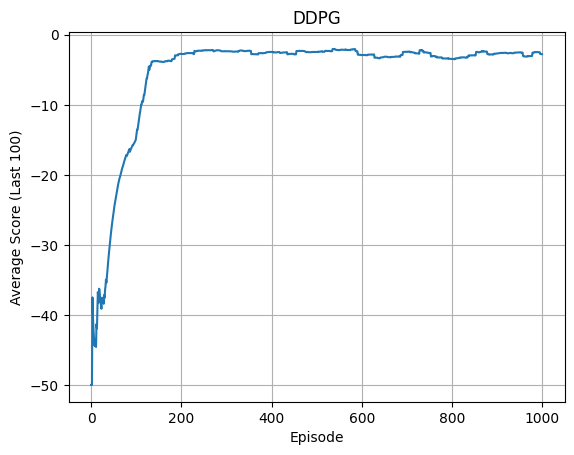

In [78]:
import matplotlib.pyplot as plt
plt.plot(avg_score_history)
plt.xlabel("Episode")
plt.ylabel("Average Score (Last 100)")
plt.title("DDPG")
plt.grid()
plt.show()

# TD3 Training

In [ ]:
import numpy as np
import gymnasium as gym
import panda_gym
# from agents.td3 import TD3Agent
# from utils.HER import her_augmentation

if __name__ == "__main__":

    n_games = 1500
    opt_steps = 64
    best_score = 0
    score_history = []
    avg_score_history = []

    env = gym.make('PandaReach-v3')
    obs_shape = env.observation_space['observation'].shape[0] + \
                env.observation_space['achieved_goal'].shape[0] + \
                env.observation_space['desired_goal'].shape[0]

    agent = TD3Agent(env=env, input_dims=obs_shape)

    for i in range(n_games):
        done = False
        truncated = False
        score = 0
        step = 0

        obs_array = []
        actions_array = []
        new_obs_array = []

        observation, info = env.reset()

        while not (done or truncated):
            curr_obs, curr_achgoal, curr_desgoal = observation.values()
            state = np.concatenate((curr_obs, curr_achgoal, curr_desgoal))

            # Choose an action
            action = agent.choose_action(state, False)

            # Excute the choosen action in the environement
            new_observation, reward, done, truncated, _ = env.step(np.array(action))
            next_obs, next_achgoal, next_desgoal = new_observation.values()
            new_state = np.concatenate((next_obs, next_achgoal, next_desgoal))

            # Store experience in the replay buffer
            agent.remember(state, action, reward, new_state, done)

            obs_array.append(observation)
            actions_array.append(action)
            new_obs_array.append(new_observation)

            observation = new_observation
            score += reward
            step += 1

        # Augmente replay buffer with HER
        her_augmentation(agent, obs_array, actions_array, new_obs_array)

        # train the agent in multiple optimization steps
        for _ in range(opt_steps):
          agent.learn()

        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        avg_score_history.append(avg_score)

        if avg_score > best_score:
            best_score = avg_score

        print(f"Episode {i} steps {step} score {score:.1f} avg score {avg_score:.1f}")
    agent.save_models()

Episode 0 steps 50 score -50.0 avg score -50.0
Episode 1 steps 50 score -50.0 avg score -50.0
---- saving models ----


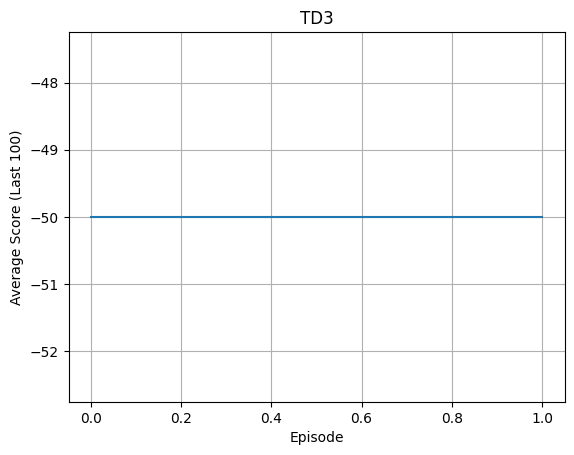

In [87]:
import matplotlib.pyplot as plt
plt.plot(avg_score_history)
plt.xlabel("Episode")
plt.ylabel("Average Score (Last 100)")
plt.title("TD3")
plt.grid()
plt.show()

SAC Agent

In [88]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense

class ValueNetwork(keras.Model):
    def __init__(self, name, model, checkpoints_dir="ckp/"):
        super(ValueNetwork, self).__init__()
        self.checkpoints_file = f"{checkpoints_dir}{model}/{name}.weights.h5"
        self.layer1 = Dense(512, activation="relu")
        self.layer2 = Dense(256, activation="relu")
        self.layer3 = Dense(256, activation="relu")
        self.v = Dense(1, activation=None)

    def call(self, state):
        x = self.layer1(state)
        x = self.layer2(x)
        x = self.layer3(x)
        v = self.v(x)
        return v


class SACAgent:
    def __init__(self, env, input_dims, alpha=0.001, beta=0.002, gamma=0.99, tau=0.005):
        self.gamma = gamma
        self.tau = tau
        self.env = env
        self.n_actions = env.action_space.shape[0]
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]
        self.input_dims = input_dims
        self.batch_size = 256
        self.memory = ReplayBuffer(10**6, input_dims, self.n_actions)
        self.log_alpha = tf.Variable(0.0, dtype=tf.float32)
        self.target_entropy = -np.prod(env.action_space.shape)

        self.actor = ActorNetwork(self.n_actions, name="sac_actor", model="SAC")
        self.critic1 = CriticNetwork(name="sac_critic1", model="SAC")
        self.critic2 = CriticNetwork(name="sac_critic2", model="SAC")
        self.value = ValueNetwork(name="value", model="SAC")
        self.target_value = ValueNetwork(name="target_value", model="SAC")

        self.actor.compile(keras.optimizers.Adam(learning_rate=alpha))
        self.critic1.compile(keras.optimizers.Adam(learning_rate=beta))
        self.critic2.compile(keras.optimizers.Adam(learning_rate=beta))
        self.value.compile(keras.optimizers.Adam(learning_rate=beta))
        self.target_value.compile(keras.optimizers.Adam(learning_rate=beta))

        self.alpha_optimizer = keras.optimizers.Adam(learning_rate=alpha)
        self.update_target_network(tau=1)

    def choose_action(self, state, evaluate=False):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        mu = self.actor(state)
        if evaluate:
            return tf.clip_by_value(mu, self.min_action, self.max_action)[0]
        else:
            noise = tf.random.normal(shape=mu.shape)
            return tf.clip_by_value(mu + noise, self.min_action, self.max_action)[0]

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.counter < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        # ---------------- Update Value ----------------
        with tf.GradientTape() as tape:
            v = tf.squeeze(self.value(states), 1)
            new_actions = self.actor(states)
            q1 = tf.squeeze(self.critic1(states, new_actions), 1)
            q2 = tf.squeeze(self.critic2(states, new_actions), 1)
            min_q = tf.minimum(q1, q2)
            entropy = self.log_alpha * tf.math.log(1e-6 + tf.reduce_sum(tf.square(new_actions), axis=1))
            value_target = min_q - entropy
            value_loss = keras.losses.MSE(v, value_target)

        value_grad = tape.gradient(value_loss, self.value.trainable_variables)
        self.value.optimizer.apply_gradients(zip(value_grad, self.value.trainable_variables))

        # ---------------- Update Critic ----------------
        with tf.GradientTape(persistent=True) as tape:
            v_next = tf.squeeze(self.target_value(next_states), 1)
            q_hat = rewards + self.gamma * v_next * (1 - dones)

            q1 = tf.squeeze(self.critic1(states, actions), 1)
            q2 = tf.squeeze(self.critic2(states, actions), 1)
            critic1_loss = keras.losses.MSE(q1, q_hat)
            critic2_loss = keras.losses.MSE(q2, q_hat)

        critic1_grad = tape.gradient(critic1_loss, self.critic1.trainable_variables)
        critic2_grad = tape.gradient(critic2_loss, self.critic2.trainable_variables)
        self.critic1.optimizer.apply_gradients(zip(critic1_grad, self.critic1.trainable_variables))
        self.critic2.optimizer.apply_gradients(zip(critic2_grad, self.critic2.trainable_variables))

        # ---------------- Update Actor ----------------
        with tf.GradientTape() as tape:
            actions_ = self.actor(states)
            q1 = self.critic1(states, actions_)
            q2 = self.critic2(states, actions_)
            min_q = tf.minimum(q1, q2)
            entropy = self.log_alpha * tf.math.log(1e-6 + tf.reduce_sum(tf.square(actions_), axis=1, keepdims=True))
            actor_loss = tf.reduce_mean(entropy - min_q)

        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

        # ---------------- Update Alpha ----------------
        with tf.GradientTape() as tape:
            actions_ = self.actor(states)
            entropy = tf.math.log(1e-6 + tf.reduce_sum(tf.square(actions_), axis=1))
            alpha_loss = -tf.reduce_mean(self.log_alpha * (entropy + self.target_entropy))

        alpha_grad = tape.gradient(alpha_loss, [self.log_alpha])
        self.alpha_optimizer.apply_gradients(zip(alpha_grad, [self.log_alpha]))

        # ---------------- Update Target Value ----------------
        self.update_target_network()

    def update_target_network(self, tau=None):
        if tau is None:
            tau = self.tau
        weights = []
        targets = self.target_value.weights
        for i, weight in enumerate(self.value.weights):
            weights.append(tau * weight + (1 - tau) * targets[i])
        self.target_value.set_weights(weights)

    def save_models(self):
        self.actor.save_weights(self.actor.checkpoints_file)
        self.critic1.save_weights(self.critic1.checkpoints_file)
        self.critic2.save_weights(self.critic2.checkpoints_file)
        self.value.save_weights(self.value.checkpoints_file)
        self.target_value.save_weights(self.target_value.checkpoints_file)

    def load_models(self):
        obs_shape = self.env.observation_space['observation'].shape[0] + \
                    self.env.observation_space['achieved_goal'].shape[0] + \
                    self.env.observation_space['desired_goal'].shape[0]
        dummy_state = tf.random.normal((1, obs_shape))
        dummy_action = tf.random.normal((1, self.n_actions))

        self.actor(dummy_state)
        self.critic1(dummy_state, dummy_action)
        self.critic2(dummy_state, dummy_action)
        self.value(dummy_state)
        self.target_value(dummy_state)

        self.actor.load_weights(self.actor.checkpoints_file)
        self.critic1.load_weights(self.critic1.checkpoints_file)
        self.critic2.load_weights(self.critic2.checkpoints_file)
        self.value.load_weights(self.value.checkpoints_file)
        self.target_value.load_weights(self.target_value.checkpoints_file)


SAC Training

In [ ]:
import numpy as np
import gymnasium as gym
import panda_gym
# from agents.sac import SACAgent
# from utils.HER import her_augmentation

if __name__ == "__main__":

    n_games = 1500
    opt_steps = 64
    best_score = -np.inf
    score_history = []
    avg_score_history = []

    env = gym.make('PandaReach-v3')
    obs_shape = env.observation_space['observation'].shape[0] + \
                env.observation_space['achieved_goal'].shape[0] + \
                env.observation_space['desired_goal'].shape[0]

    agent = SACAgent(env=env, input_dims=obs_shape)

    for i in range(n_games):
        done = False
        truncated = False
        score = 0
        step = 0

        obs_array = []
        actions_array = []
        new_obs_array = []

        observation, info = env.reset()

        while not (done or truncated):
            curr_obs, curr_achgoal, curr_desgoal = observation.values()
            state = np.concatenate((curr_obs, curr_achgoal, curr_desgoal))

            # Choose an action
            action = agent.choose_action(state, evaluate=False)

            # Execute the action
            new_observation, reward, done, truncated, _ = env.step(np.array(action))
            next_obs, next_achgoal, next_desgoal = new_observation.values()
            new_state = np.concatenate((next_obs, next_achgoal, next_desgoal))

            # Store the experience
            agent.remember(state, action, reward, new_state, done)

            # Save for HER
            obs_array.append(observation)
            actions_array.append(action)
            new_obs_array.append(new_observation)

            observation = new_observation
            score += reward
            step += 1

        # HER Augmentation
        her_augmentation(agent, obs_array, actions_array, new_obs_array)

        # Perform multiple training steps
        for _ in range(opt_steps):
            agent.learn()

        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        avg_score_history.append(avg_score)

        if avg_score > best_score:
            best_score = avg_score

        print(f"Episode {i} steps {step} score {score:.2f} avg score {avg_score:.2f}")

    agent.save_models()


Episode 0 steps 50 score -50.00 avg score -50.00
Episode 1 steps 50 score -50.00 avg score -50.00


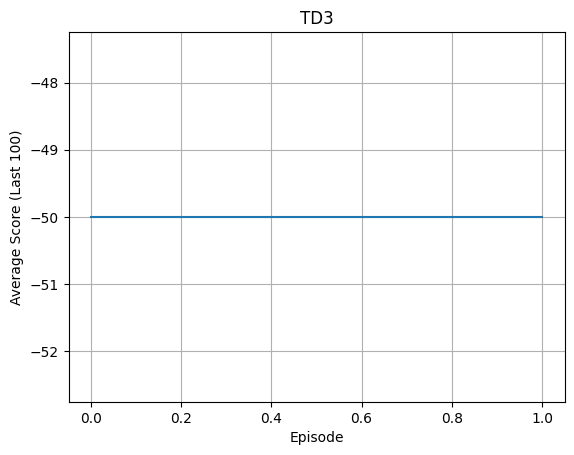

In [90]:
import matplotlib.pyplot as plt
plt.plot(avg_score_history)
plt.xlabel("Episode")
plt.ylabel("Average Score (Last 100)")
plt.title("TD3")
plt.grid()
plt.show()

In [83]:
!pip install numpngw

# Training with model save

---- loading models ----


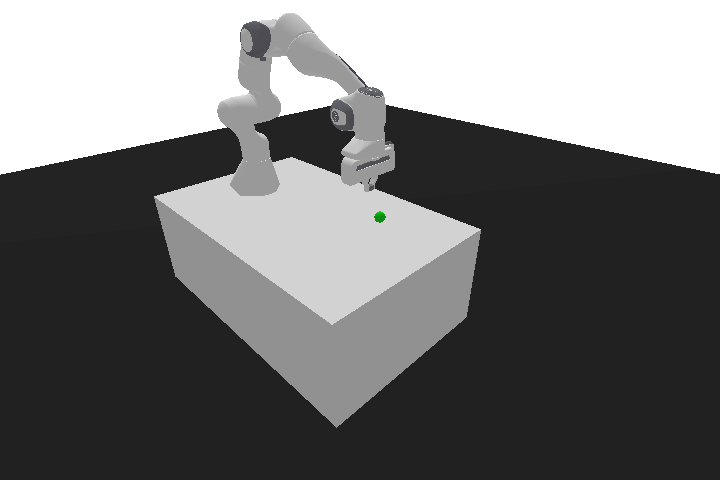

In [84]:
import gymnasium as gym
import panda_gym
from numpngw import write_apng
from IPython.display import Image
# from agents.ddpg import DDPGAgent

env = gym.make("PandaReach-v3", render_mode="rgb_array")
obs_shape = env.observation_space['observation'].shape[0] + \
                env.observation_space['achieved_goal'].shape[0] + \
                env.observation_space['desired_goal'].shape[0]

# Choose your trained agent : DDPG or TD3
agent = DDPGAgent(env=env, input_dims=obs_shape)
# load pre-trained networks weights
agent.load_models()

observation, info = env.reset()

# Stores frames of robot arm moving in Reacher env
images = [env.render()]

done = False
truncated = False
for i in range(200):
    curr_obs, curr_achgoal, curr_desgoal = observation.values()
    state = np.concatenate((curr_obs, curr_achgoal, curr_desgoal))

    # Choose an action using pre-trainded RL agent
    action = agent.choose_action(state)

    # Excute the choosen action in the environement
    new_observation, reward, done, truncated, _ = env.step(np.array(action))
    images.append(env.render())
    observation = new_observation

    if done or truncated:
        observation, info = env.reset()
        images.append(env.render())

env.close()

# save frames : real-time rendering = 40 ms between frames
write_apng("anim.png", images, delay=60)
# show movements
Image(filename="anim.png")